<a href="https://colab.research.google.com/github/rafaelnduarte/Churn_Prediction/blob/main/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![LinkedIn](https://img.shields.io/badge/LinkedIn-rafaelnduarte-blue.svg)](https://www.linkedin.com/in/rafael-n-duarte)
[![GitHub](https://img.shields.io/badge/GitHub-rafaelnduarte-purple.svg)](https://github.com/rafaelnduarte)

# Churn Prediction

**"Churn rate"** , or simply **"churn"**, represents the rate of customer base evasion. In services such as Spotify or Netflix, it would represent the rate of subscription cancellations.

<p align=center>
<img src="https://images.unsplash.com/photo-1518893494013-481c1d8ed3fd?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1470&q=80" width="60%"></p>

It is of utmost importance for management, and its analysis over time can show that there is a problem that needs to be addressed.

"Churn" can also be used to identify potential cancellations in advance and promote targeted actions to try to retain such customers. This metric should receive attention because the Cost of Customer Acquisition (CAC) is typically higher than the cost to retain them. In other words, a high value for the churn rate is undesirable.

## Data Acquisition

The data used in this project was originally made available at [IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), and deals with a typical problem of a telecommunications company. The complete dataset can be found [here](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Although there is no explicit information available, the column names allow for an understanding of the problem

In [24]:
# installing the necessary packages
!pip install scikit-plot -q
!pip install --upgrade imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# importing the data
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# checking the first entries
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Visualizing the first 5 entries allows us to understand structure of the dataset. Even though there is no extra material with more details about how the data was collected and organized, it is stills possible to understand and work with this data.

As shown below, the dataset is composed of 7043 entries and 21 variables.

In [26]:
print("Rows:\t\t{}".format(df.shape[0]))
print("Columns:\t{}".format(df.shape[1]))

Rows:		7043
Columns:	21


## Exploratory Data Analysis

To start off this project, let's check the integrity and usability of the dataset.

To do this, I will print out the amount of missing data, the column names, the variable types per column, and the unique values per column. This last one, specifically, will help in identifying potentially categorical variables.

In [27]:
print("Missing Data (total):\t{}\n".format(df.isnull().sum().values.sum()))
print(df.isnull().sum() / df.shape[0])
print("\nFeatures:\n{}\n".format(df.columns.values))
print("Unique Values (by column):\n{}\n".format(df.nunique()))
print("Variable Type (by column)\n{}".format(df.dtypes))

Missing Data (total):	0

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

Features:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Unique Values (by column):
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependent

Let's go over the highlights:


* `Churn` is the target variable, indicating the situation of the client regarding this metric.
* `TotalCharges` should be a `float`, but is currently `string`.
    * As of right now, there aren't any missing values. However, we have string values that could be understood as missing.
* Several features must be converted to numeric.
    * There are several binary features, including the target variable, as well as categorical values, each of them indicating a different category.


## Data Cleaning

When analyzing `TotalCharges`, we have identified that the missing data was entered as the string `""`. If we simply try to transform it into float(""), the interpreter returns an error.

So, in order to convert it properly, I created a function to handle this exception. In the end, I identified missing data and replaced it with the median value of the column.

Below, I also took the opportunity to delete the customerID column, which would be unnecessary throughout this project.

In [28]:
def converter_str_float(entry):
    """
    Converting string objects into float 

    # Arguments
        entry: string

    # Returns
        If possible, value converted as float.
        NaN, if the transformation isn't possible.
    """

    try:
        return float(entry)
    except ValueError:
        return np.nan

# copying the dataframe
df_clean = df.copy()

# removing custumerID
df_clean.drop("customerID", axis=1, inplace=True)

# converting strings in TotalCharges to float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(converter_str_float)

# checking for missing data
print("Missing Data in 'TotalCharges' (before replacing with Median):\t{}\n".format(df_clean["TotalCharges"].isnull().sum()))

# replacing NaN with Median
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

Missing Data in 'TotalCharges' (before replacing with Median):	11



Even though the dataset is mostly composed of binary or categorical variables, it is possible to see below, using the `describe` method, that there are no indications of the presence of outliers.

In [29]:
df_clean.describe() 

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Analyzing boxplots for `MonthlyCharges` and `TotalCharges`, the distribution seems to reinforce our initial hypothesis. 

There doesn't seem to be data points above or below the limits.

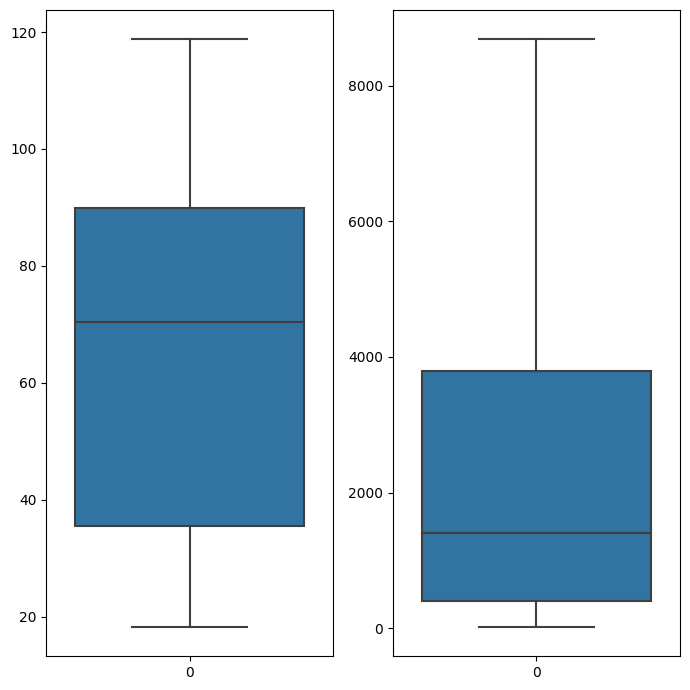

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))
sns.boxplot(df_clean['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_clean['TotalCharges'], ax=ax[1])
plt.tight_layout()

In this case, we can take the variable `tenure`, which indicates how long the client has been a client, as an indication of the quality of the relationship of the client with the company.

Since we don't have an official documentation regarding the dataset, let's assume the time unit used in this variable is months.

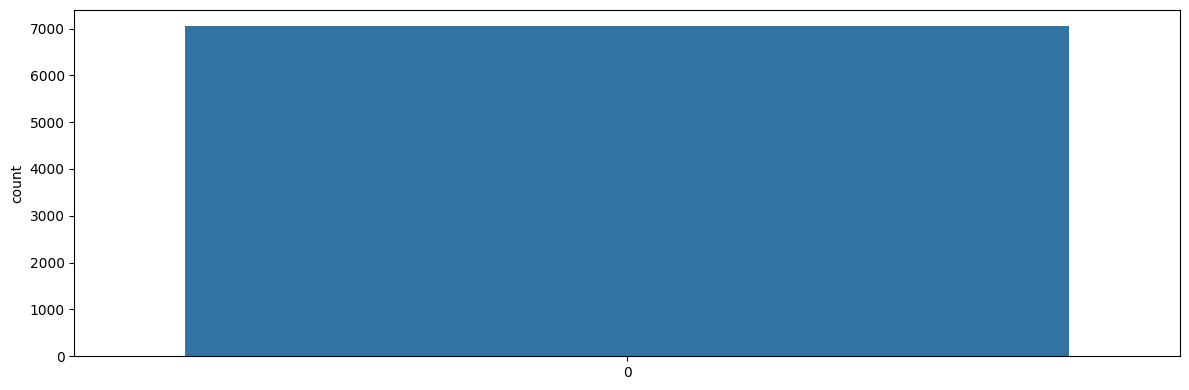

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(df['tenure'])
plt.tight_layout()

When dealing with categorical variables, it's important to check for unique values. It allows us to identify when different labels can mean the same thing.

For example, you can see below that we have the following entries:`No`, `No phone service` and `No internet service`, which can mean the same thing.

It's a valid point. However, since we can't know for sure, let's consider them as different values.

In [32]:
# checking unique values for object variables
np.unique(df_clean.select_dtypes('object').values)

array(['Bank transfer (automatic)', 'Credit card (automatic)', 'DSL',
       'Electronic check', 'Female', 'Fiber optic', 'Mailed check',
       'Male', 'Month-to-month', 'No', 'No internet service',
       'No phone service', 'One year', 'Two year', 'Yes'], dtype=object)

To identify if the dataset shows any kind of bias, let's check the count of `Male` and `Female`.

This type of bias doesn't seem relevant in this specific case. However, there are many instances where it could be a real problem. For instance, if we were working on a project related to a hiring process.

As we can see below, the distribution is balanced.

In [33]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


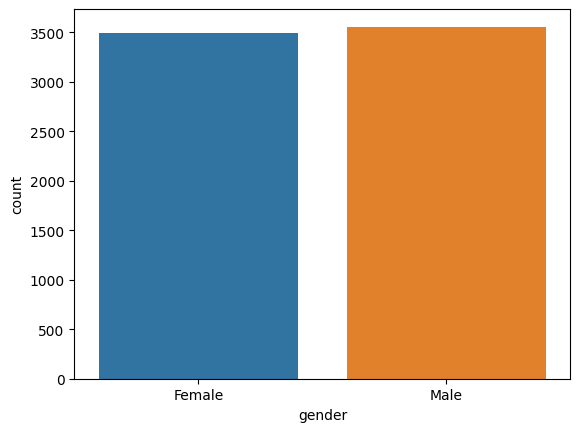

In [34]:
sns.countplot(x='gender', data=df);

Last but not least, it's important to check whether the dataset is balanced or not, when it comes to the target variable.

As we can see below, `No` is a lot more common than `Yes`. This must be taken into account when building a **Machine Learning** model for this dataset.

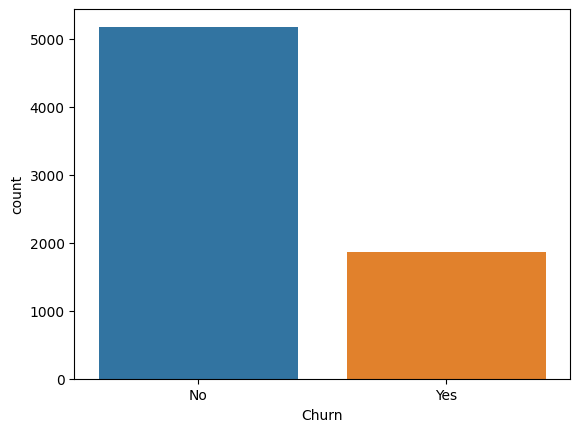

In [35]:
sns.countplot(x='Churn', data=df);

## Data Pre-Processing for Machine Learning

Let's prepare the data in order to fit into a Machine Learning model.

### The Process

For binary features, I will use `LabelEncoder`. This includes our target variable, `Churn`.

The next step is separating numerical and categorical variables. Categorical variables will be transformed into Dummy Variables, so they can be used by different models.

In [36]:
# pre-processing variables
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# creating a copy of the dataframe
df_proc = df_clean.copy()

# Label Encoding for Binary Variables
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding for multi-class variables
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# checking the new dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


## Machine Learning

With the previous pre-processing, the data is ready to be used in a Machine Learning model.

Before we go into hyperparameter tuning, feature engineering, feature selection, etc, let's fit the data into a simple model, to be used as baseline for the project.

However, it's important to split the data here, before we move forward.

In [37]:
# isolating the target variable
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y)

I will use `cross-validation` to estimate the error for our baseline.

To make the process easier, I created a `val_model` function.

The models will be evaluated on `recall`.

In [38]:
def val_model(X, y, clf, quite=False):
    """
    Cross Validation Function.

    # Arguments
        X: DataFrame, independent variables.
        y: Series, vector, target variable.
        clf: Scikit-learn Classifier.
        quiet: bool, indicating whether the function should print the results.

    # Returns
        float, cross-validation avergae score.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

For the baseline, I will use `Random Forest`, without any type of tuning, with the training data.

In [39]:
# creating baseline
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.47 (+/- 0.02)


Now that we have a baseline, let's move on, and try to improve our results.

For this project, after some testing I've found that `Under Sampling` yielded the best results. Also, following recommendations for Under Sampling, I've decided to apply `Standard Scaler` to the data.

**Warning**

Keep in mind that only the **training** data will be balanced. The test data must remain untouched.

In [40]:
# standardizing the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)


# oversample = SMOTE()
# X_train, y_train = oversample.fit_sample(X_train, y_train)

# under sampling
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Now, let's try fitting diferrent models for cross validation, to find out which model works best for our specific problem.

* Random Forest
* Decision Tree
* Stochastic Gradient Descent
* SVC
* Logistic Regression
* LightGBM



In [41]:
# instantiating the models
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# evaluating results (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.769784
DecisionTreeClassifier,0.681295
SGDClassifier,0.733813
SVC,0.790647
LogisticRegression,0.807194
XGBClassifier,0.748201
LGBMClassifier,0.772662


Given the characteristics of the problem and the performance during previous executions, I opted for XGBoost, which was practically tied with Logistic Regression.

My understanding is that parameter tuning can further improve the quality of the solution. After some testing adjusting parameters for Logistic Regression and some of the other top performing models, XGBoost performed better after optimization.

## Hyperparameter Optimization

XGBoost has numerous parameters. Some have a greater impact on the model's quality, while others have less. A good practice is to set a learning rate and number of estimators, tune other parameters, and then check other learning rates.

Below, I will adjust the number of estimators. The model was instantiated with `learning_rate=0.1`.

In [43]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
 'n_estimators':range(0,1000,50),
}

# identifying the best parameters
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# checking results
print("Best: {} for {}".format(grid_result.best_score_, grid_result.best_params_))

Best: 0.7848920863309352 for {'n_estimators': 50}


With the number of estimators set at 50, let's optimize `max_depth` and `min_child_weight`.

In [44]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50)

param_grid = {
 'max_depth':range(1,8,1),
 'min_child_weight':range(1,5,1)
}

# identifying the best parameters
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# checking results
print("Best: {} for {}".format(grid_result.best_score_, grid_result.best_params_))

Best: 0.8187050359712231 for {'max_depth': 1, 'min_child_weight': 1}


After optimization, we have found that the ideal parameters are `max_depth=1` and `min_child_weight=1`.

Next step, let''s optimize `gamma`.

In [45]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=1, min_child_weight=1)

param_grid = {
 'gamma':[i/10.0 for i in range(0,5)]
}

# identifying the best parameters
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# checking results
print("Best: {} for {}".format(grid_result.best_score_, grid_result.best_params_))

Best: 0.823021582733813 for {'gamma': 0.0}


Finally, with `gamma=0`, let's test other values for `learning_rate` to make sure we have the best parameters.

In [46]:
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)

param_grid = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}

# identifying the best parameters
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# checking results
print("Best: {} for {}".format(grid_result.best_score_, grid_result.best_params_))

Best: 0.8812949640287769 for {'learning_rate': 0.001}


Assuming `recall` is the most important metric for this projetct, we can see that a lower value for `learning_rate` was the best call.

Now, it's time to train the model, and check the results on the test dataset. This is going to be the first time the model receives the test dataset.

              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1282
           1       0.44      0.90      0.59       479

    accuracy                           0.66      1761
   macro avg       0.69      0.73      0.65      1761
weighted avg       0.80      0.66      0.68      1761

AUC: 0.7336



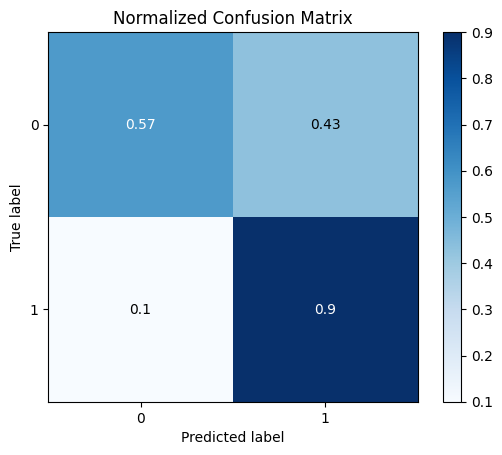

In [47]:
# final model
xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

# making predictions
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# plotting area under the curve
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotting confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

## Conclusions

The results were satisfactory, taking into account that `recall` was the main metric for optimization. Test and training results are close, which is a good sign, and indicates the parameters have been decently tuned.

There's still a lot of room for imporivement. We can try different balancing techniques, feature engineering, feature selection, etc.

This is a very complex and interesting project, where the data analysis and machine learning can be really helpful.

I hope this MVP showed promisse, and that you found this project interesting and instructing.

Should you have any questions, I'd be happy to talk about the project.

[![LinkedIn](https://img.shields.io/badge/LinkedIn-rafaelnduarte-blue.svg)](https://www.linkedin.com/in/rafael-n-duarte)
[![GitHub](https://img.shields.io/badge/GitHub-rafaelnduarte-purple.svg)](https://github.com/rafaelnduarte)
